
### Weather observations from Synoptic Weather 
Here, we demonstrate functions that download observation data from Synoptic Weather using the package `synopticpy`.

Our aim is to create straightforward API calls to download weather data for given radius, variables, times, etc. 

We should demonstrate visualizations of the data, both as a sanity check and for reports/publications.

Also:
* Show representative observation creation 
* More...

In [12]:
import os 
import datetime

import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from obs.obsdata import ObsData


In [ ]:
obs_end_dt = datetime.datetime(2023,3,15,0,0,0)
# obs_start_dt = obs_end_dt - datetime.timedelta(days=5*30)
obs_start_dt = obs_end_dt - datetime.timedelta(hours=72)

# radius is 45 in v0.1 but could be bigger to capture pseudo-lapse-rate better (temperature observations up the slope)
# Uses Pelican Lake as centre point, default (UCL21)
obs = ObsData(obs_start_dt, obs_end_dt, radius_mi=50,)
print("Obs loaded")
obs.df.head(10)

In [ ]:
# column names that contain "_set_":
obs.df.columns[obs.df.columns.str.contains("_set_")]

In [ ]:
# column names that contain "_value_":
obs.df.columns[obs.df.columns.str.contains("_value_")]


In [ ]:
# For each _set_ column, count how many non-NaNs appear out of the total number of rows
for col in obs.df.columns[obs.df.columns.str.contains("_set_")]:
    print(f"{col}: {obs.df[col].count()} / {obs.df.shape[0]}")
    

In [ ]:
import re
# At the time of the first non-NaN value for each of the columns above, show what the
# value for the station is for the variable named the same up to the "_set_*" suffix
# where * can be various things like 1, 1d, etc
for col in obs.df.columns[obs.df.columns.str.contains("_set_")]:
    first_non_nan = obs.df[col].first_valid_index()
    print(f"{col} first non-NaN: {first_non_nan}")
    if first_non_nan:
        # Print the columns with and without the _set_ suffix
        print(obs.df.loc[first_non_nan, col])
        print(obs.df.loc[first_non_nan, re.sub(r'_set_.*', '', col)])
        # Print three blank lines as divider 
        print("\n"*3)

In [ ]:
# See the dtype of each column of the obs.df 
obs.df.dtypes

In [ ]:
# Now for obs.meta_df
obs.meta_df.dtypes

In [ ]:
obs.meta_df

## Start here for loading the data and exploring per winter

In [18]:
# This is the old instance and we don't want to accidentally use it
del obs

In [23]:
# Test loading the data
df, meta_df = ObsData.load_dfs("../data", "UB_obs_2016.parquet")
df.head(10)

,air_temp,altimeter,ceiling,dew_point_temperature_set_1,dew_point_temperature,pressure,sea_level_pressure_set_1,sea_level_pressure,wind_direction,wind_speed,...,wind_v,stid,snow_depth,snow_smoothed,snow_water_equiv,solar_radiation,soil_temp,soil_temp_set_5,PM_25_concentration,ozone_concentration
date_time,,,,,,,,,,,,,,,,,,,,,
2015-12-01 00:53:00+00:00,-7.2,101930.250000,NaN,-11.700000,-11.770000,83973.273438,102450.0,102776.968750,360.0,2.06,...,-2.060,KVEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-01 01:53:00+00:00,-10.0,101930.250000,NaN,-12.800000,-12.850000,83973.273438,102540.0,102993.906250,280.0,2.06,...,-0.358,KVEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-01 02:53:00+00:00,-11.1,101997.976562,NaN,-13.900000,-13.950000,84029.070312,102620.0,103149.007812,290.0,3.09,...,-1.057,KVEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-01 03:53:00+00:00,-11.7,102065.703125,NaN,-15.000000,-15.060000,84084.859375,102690.0,103265.140625,0.0,0.00,...,0.000,KVEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-01 04:53:00+00:00,-12.8,102133.429688,NaN,-15.600000,-15.650000,84140.656250,102730.0,103421.671875,260.0,3.09,...,0.537,KVEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-01 05:53:00+00:00,-13.3,102167.296875,NaN,-16.100000,-16.150000,84168.562500,102810.0,103496.242188,280.0,2.57,...,-0.446,KVEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-01 06:53:00+00:00,-13.3,102167.296875,NaN,-16.100000,-16.150000,84168.562500,102820.0,103496.242188,280.0,2.06,...,-0.358,KVEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-01 07:53:00+00:00,-13.9,102167.296875,NaN,-17.200001,-17.260000,84168.562500,102790.0,103544.812500,280.0,2.06,...,-0.358,KVEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-01 08:53:00+00:00,-14.4,102133.429688,NaN,-17.799999,-17.860001,84140.656250,102780.0,103551.132812,280.0,2.06,...,-0.358,KVEL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
meta_df

,KVEL,RSVL,CUPH,MMTU1,TCKU1,DIAU1,FIVU1,MCKU1,USWU1,SFLU1,...,4276P,PC266,PC353,UB1UT,PC486,UGSDV,UTELP,UTMTH,PC558,PC561
DISTANCE,20.26,22.29,40.84,32.16,39.04,37.87,37.27,42.98,34.35,21.18,...,26.36,25.48,16.98,15.51,29.22,15.57,17.01,40.08,23.64,30.35
ELEVATION,5262.0,5151.0,5725.0,9552.0,9448.0,7730.0,7484.0,6722.0,6469.0,5240.0,...,4803.0,8426.0,5947.0,5070.0,6149.0,5032.0,5692.0,6695.0,5818.0,5364.0
ELEV_DEM,5269.0,5200.1,5590.6,9583.3,9471.8,7729.7,7483.6,6702.8,6423.9,5226.4,...,NaN,8441.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ID,61,878,902,1494,1509,2336,2337,2348,2360,2365,...,173578,175633,217351,237823,238714,239856,243538,245316,245317,245375
MNET_ID,1,1005,19,25,25,2,2,2,2,2,...,208,247,247,153,247,153,4,4,247,247
NAME,Vernal Airport,ROOSEVELT-UNION HS,STARVATION DAM,MOSBY MTN.,TROUT CREEK,DIAMOND RIM,FIVE MILE,MCCOOK RIDGE,UPPER SAND WASH,YAMPA PLATEAU,...,Dino Ozone Station,Little Mountain,Vernal West,CIGE 226,Little Valley,Desert View (Myton) EC,SR-121 at MP 31.5 East Lapoint,SR-87 at MP 16 Mountain Home,Ashley,Duchesne River
RECORD_END,2024-10-10 07:53:00+00:00,2002-02-13 21:00:00+00:00,NaT,2024-10-10 07:00:00+00:00,2024-10-10 07:00:00+00:00,2024-10-10 07:27:00+00:00,2024-10-10 07:28:00+00:00,2024-10-10 07:27:00+00:00,2024-10-10 07:27:00+00:00,2024-10-10 07:27:00+00:00,...,2022-05-27 03:10:00+00:00,2024-10-10 07:50:00+00:00,2024-10-10 07:50:00+00:00,2024-10-10 07:15:00+00:00,2024-10-10 07:50:00+00:00,2024-10-10 07:30:00+00:00,2024-10-10 07:50:00+00:00,2024-10-10 07:50:00+00:00,2024-10-10 07:50:00+00:00,2024-10-10 07:50:00+00:00
RECORD_START,1997-01-01 00:00:00+00:00,1999-01-12 00:00:00+00:00,NaT,2000-01-20 00:00:00+00:00,2000-01-20 00:00:00+00:00,1997-01-01 00:00:00+00:00,1997-05-27 00:00:00+00:00,1997-01-01 00:00:00+00:00,1997-01-01 00:00:00+00:00,1997-01-01 00:00:00+00:00,...,2022-04-26 21:10:00+00:00,2022-06-30 20:15:00+00:00,2023-05-16 08:14:00+00:00,2024-05-13 18:00:00+00:00,2024-06-11 07:40:00+00:00,2024-07-12 19:30:00+00:00,2024-08-23 00:40:00+00:00,2024-09-26 20:40:00+00:00,2024-09-27 07:40:00+00:00,2024-10-03 07:30:00+00:00
RESTRICTED,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
STATE,UT,UT,UT,UT,UT,UT,UT,UT,UT,UT,...,UT,UT,UT,UT,UT,UT,UT,UT,UT,UT


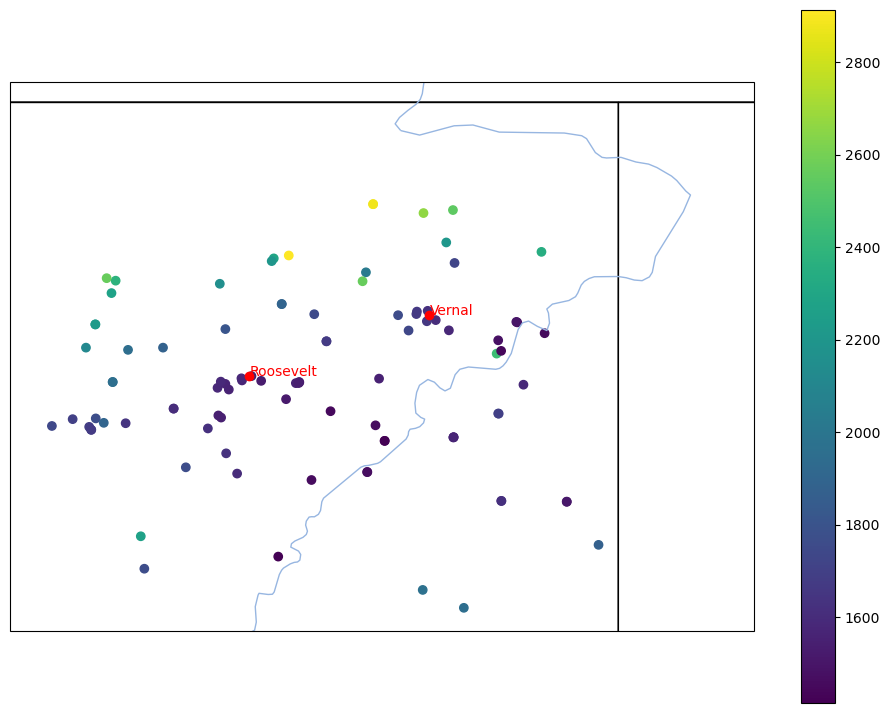

In [25]:
# Visualise station locations 
fig = plt.figure(figsize=(12, 9))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax = plt.axes(projection=osm_img.crs)  # project using coordinate reference system (CRS) of street map?

lats = []
lons = []
elevs = []
for stid in meta_df.columns:
    # Convert to metres here - TODO a nicer way! 
    elevs.append(meta_df[stid].loc["ELEV_DEM"]*0.304)
    lats.append(meta_df[stid].loc["latitude"])
    lons.append(meta_df[stid].loc["longitude"])    

sc = ax.scatter(lons, lats, c=elevs, transform=ccrs.PlateCarree())#, **scatter_kwargs)
    
cbar = fig.colorbar(sc)

# Add reference towns in RED
towns = {
    "Vernal":[40.4555,-109.5287],
    "Roosevelt":[40.2994,-109.9888],
}

for town,latlon in towns.items():
    ax.scatter(latlon[1], latlon[0], color='red',transform=ccrs.PlateCarree())#, **scatter_kwargs)
    ax.text(latlon[1],latlon[0],town,color='red',transform=ccrs.PlateCarree())


ax.add_feature(cfeature.STATES.with_scale("10m"))
ax.add_feature(cfeature.RIVERS.with_scale("10m"))

extent = [-110.6,-108.7,39.65,41.05]
ax.set_extent(extent)  # set extents


In [28]:
# Subset df to columns containing "soil_temp".
soil_temp_cols = df.columns[df.columns.str.contains("soil_temp")]
soil_df = df[soil_temp_cols].dropna(how='all')
soil_df

,soil_temp,soil_temp_set_5
date_time,,
2015-12-01 00:00:00+00:00,2.26,NaN
2015-12-01 00:10:00+00:00,2.27,NaN
2015-12-01 00:20:00+00:00,2.27,NaN
2015-12-01 00:30:00+00:00,2.26,NaN
2015-12-01 00:40:00+00:00,2.26,NaN
...,...,...
2016-03-14 23:20:00+00:00,5.99,NaN
2016-03-14 23:30:00+00:00,6.00,NaN
2016-03-14 23:40:00+00:00,6.01,NaN


In [29]:
soil_df.describe()    

,soil_temp,soil_temp_set_5
count,44262.000000,651.000000
mean,0.213714,-0.288018
std,2.406811,0.853569
min,-3.410000,-2.220000
25%,-1.730000,0.040000
50%,0.070000,0.090000
75%,1.190000,0.110000
max,6.320000,0.140000
